### Figure 3: Mean and STD bias plot

In [1]:
import numpy as np
import matplotlib
from libpysal.weights import lat2W
import seaborn as sns
import matplotlib.pyplot as plt
from utils.plot import make_anomaly_cmap
import warnings
import xesmf as xe
from scipy import stats
from utils.data import load_tc_data
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))
# TODO: rename 'inputs' to bilinear interpolation
# TODO: NH / SH split

/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def plot_anomaly(inputs,cmap,plot='save',vmin=-1,vmax=1,levels = False,mode='validation'):  
        fig, ax = plt.subplots(figsize=(5, 5))  
        ax.set_title('Anomaly')
        im = ax.imshow(inputs, interpolation='nearest', vmin=vmin,vmax=vmax,extent=None,cmap=cmap)
        ax.set(xticklabels=[])
        ax.set(yticklabels=[])
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        if levels:
                plt.colorbar(im, cax=cax,levels = levels) # Similar to fig.colorbar(im, cax = cax)
        else:
                plt.colorbar(im, cax=cax)
        # plt.colorbar(im)

        if plot == 'save':
                plt.savefig('figs/input_images_%s.png' % mode,bbox_inches='tight')
                plt.clf()
        else:
                plt.show()

In [3]:
model = ''
# set mode
mode = 'validation'
# print(np.load('/user/home/al18709/work/tc_data_mswep/valid_X.npy').shape)

real,inputs,pred_cnn,pred_vaegan,pred_gan,pred_vaegan_ensemble,pred_gan_ensemble,meta = load_tc_data(set='test',results='test')
real_x,inputs_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x,meta_extreme_valid = load_tc_data(set='extreme_valid',results='test')
# inputs = np.load('/user/home/al18709/work/gan_predictions_20/validation_input-opt_improve.npy')[:,:,:,0]
# hrmip = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3p/historical/storm_rain.npy')[-28000:]

# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
# regridder = xe.Regridder(grid_in, grid_out, "nearest_s2d")
inputs_hr = regridder(inputs)
inputs_hr_x = regridder(inputs_x)
# hrmip_hr = regridder(hrmip)


In [4]:
def mean(real,pred):
	# mean_real = np.nanmean(real,axis=0)
	# mean_pred = np.nanmean(pred,axis=0)
	mean_real = stats.trim_mean(real, 0.001)
	mean_pred = stats.trim_mean(pred, 0.001)

	mean_anom = mean_pred - mean_real
	mean_anom = mean_anom/mean_real * 100
	return mean_anom

def std(real,pred):
	std_real = np.nanstd(real,axis=0)
	std_pred = np.nanstd(pred,axis=0)
	std_anom = std_pred - std_real
	std_anom = std_anom/std_real * 100
	return std_anom


In [5]:
# calc means etc

mean_anom_unet = mean(real,pred_cnn)
std_anom_unet = std(real,pred_cnn)
mean_anom_vaegan = mean(real,pred_vaegan)
std_anom_vaegan = std(real,pred_vaegan)
mean_anom_gan = mean(real,pred_gan)
std_anom_gan = std(real,pred_gan)
mean_anom_inputs = mean(real,inputs_hr)
std_anom_inputs = std(real,inputs_hr)


inputs_x_max = np.max(inputs_x,axis=(1,2))
max_idx = list(np.argpartition(inputs_x_max, -100)[-100:])
pred_vaegan_x = pred_vaegan_x[max_idx]
pred_gan_x = pred_gan_x[max_idx]
real_x = real_x[max_idx]
pred_vaegan_ensemble_x = pred_vaegan_ensemble_x[max_idx]
pred_gan_ensemble_x = pred_gan_ensemble_x[max_idx]
inputs_hr_x = inputs_hr_x[max_idx]
pred_cnn_x = pred_cnn_x[max_idx]

mean_anom_unet_x = mean(real_x,pred_cnn_x)
std_anom_unet_x = std(real_x,pred_cnn_x)
mean_anom_vaegan_x = mean(real_x,pred_vaegan_x)
std_anom_vaegan_x = std(real_x,pred_vaegan_x)
mean_anom_gan_x = mean(real_x,pred_gan_x)
std_anom_gan_x = std(real_x,pred_gan_x)
mean_anom_inputs_x = mean(real_x,inputs_hr_x)
std_anom_inputs_x = std(real_x,inputs_hr_x)




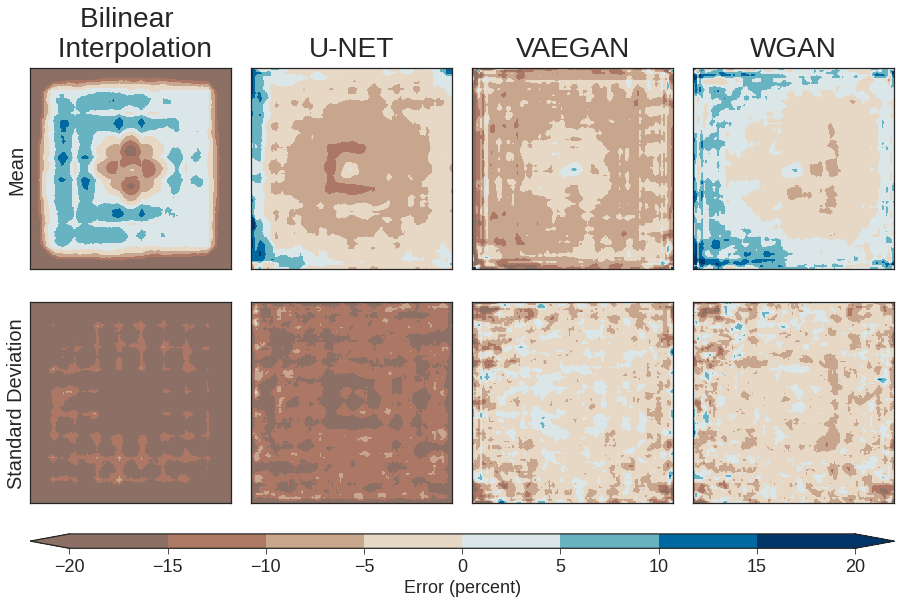

In [6]:
plot='save'
precip_cmap,precip_norm = make_anomaly_cmap()
plt.style.use('seaborn-ticks')
n = 2
m = 4
if plot == 'save':
		fig, axes = plt.subplots(n, m, figsize=(5*m, 5*n), sharey=True)
else:
		print('show')
		fig, axes = plt.subplots(n, m, figsize=(2*m, 2*n), sharey=True)

cmap = precip_cmap
cmap_norm = matplotlib.colors.BoundaryNorm([-20,-15,-10,-5,0,5,10,15,20], cmap.N)

axes[0,0].imshow(mean_anom_inputs, extent=None,cmap=cmap,norm=cmap_norm)
axes[0,1].imshow(mean_anom_unet, extent=None,cmap=cmap,norm=cmap_norm)
axes[0,2].imshow(mean_anom_vaegan, extent=None,cmap=cmap,norm=cmap_norm)
axes[0,3].imshow(mean_anom_gan, extent=None,cmap=cmap,norm=cmap_norm)
axes[1,0].imshow(std_anom_inputs, extent=None,cmap=cmap,norm=cmap_norm)
axes[1,1].imshow(std_anom_unet, extent=None,cmap=cmap,norm=cmap_norm)
axes[1,2].imshow(std_anom_vaegan, extent=None,cmap=cmap,norm=cmap_norm)
m = axes[1,3].imshow(std_anom_gan, extent=None,cmap=cmap,norm=cmap_norm)

# axes[0,0].imshow(mean_anom_inputs_x, interpolation='nearest', extent=None,cmap=cmap,norm=cmap_norm)
# axes[0,1].imshow(mean_anom_unet_x, interpolation='nearest', extent=None,cmap=cmap,norm=cmap_norm)
# axes[0,2].imshow(mean_anom_vaegan_x, interpolation='nearest', extent=None,cmap=cmap,norm=cmap_norm)
# axes[0,3].imshow(mean_anom_gan_x, interpolation='nearest', extent=None,cmap=cmap,norm=cmap_norm)
# axes[1,0].imshow(std_anom_inputs_x, interpolation='nearest', extent=None,cmap=cmap,norm=cmap_norm)
# axes[1,1].imshow(std_anom_unet_x, interpolation='nearest', extent=None,cmap=cmap,norm=cmap_norm)
# axes[1,2].imshow(std_anom_vaegan_x, interpolation='nearest', extent=None,cmap=cmap,norm=cmap_norm)
# m = axes[1,3].imshow(std_anom_gan_x, interpolation='nearest', extent=None,cmap=cmap,norm=cmap_norm)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])



# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.3, 0.15, 0.6, 0.02])
cbar = fig.colorbar(m, cax=cbar_ax,orientation='horizontal',ticks=[-20,-15,-10,-5,0,5,10,15,20],extend='both')
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Error (percent)',fontsize=18)

# set all titles and labels
fig.subplots_adjust(left=0.3)
axes[0,0].set_ylabel('Mean',fontsize=20,rotation=90)
axes[1,0].set_ylabel('Standard Deviation',fontsize=20,rotation=90)
# axes[0,2].set_title('Mean \n (extremes)',fontsize=24)
# axes[0,3].set_title('Standard Deviation \n (extremes)',fontsize=24)
axes[0,0].set_title('Bilinear \n Interpolation',rotation=0,fontsize=28,va='bottom')
axes[0,1].set_title('U-NET',rotation=0,fontsize=28,va='bottom')
axes[0,2].set_title('VAEGAN',rotation=0,fontsize=28,va='bottom')
axes[0,3].set_title('WGAN',rotation=0,fontsize=28,va='bottom')



# axes[0,0].text(-0.3, 1.2, 'a.', transform=axes[0,0].transAxes, size=32, weight='bold')
# plt.tight_layout()
# plt.colorbar(m)
plt.subplots_adjust(hspace=-0.2,wspace=0.1)
# fig.subplots_adjust(right=5)
plt.savefig('figure3.png',bbox_inches='tight',dpi=600)
# plt.show()

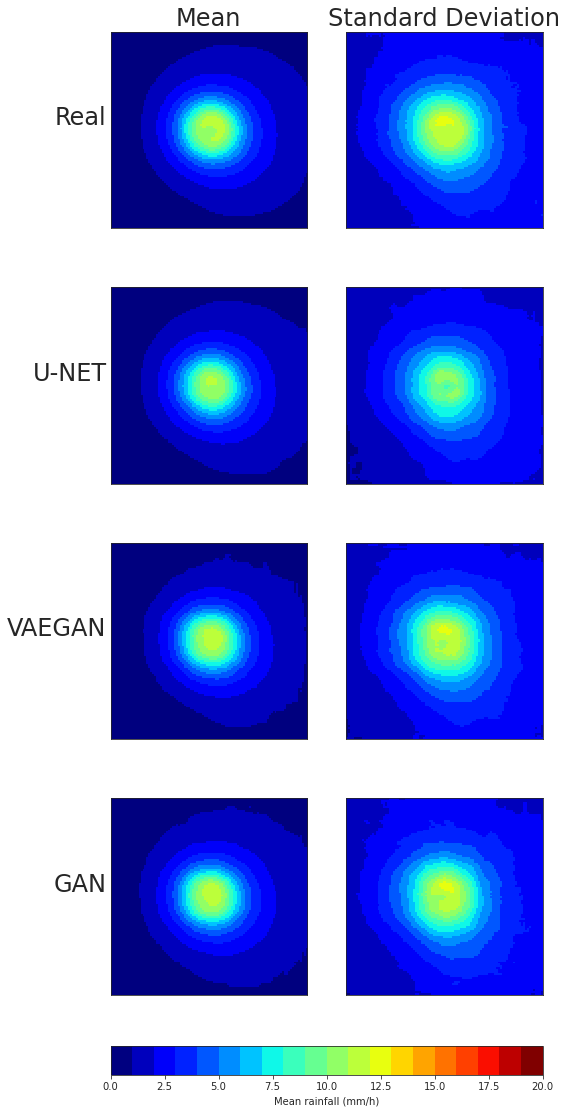

In [ ]:
plot='save'
n = 4
m = 2
if plot == 'save':
		fig, axes = plt.subplots(n, m, figsize=(5*m, 5*n), sharey=True)
else:
		print('show')
		fig, axes = plt.subplots(n, m, figsize=(2*m, 2*n), sharey=True)

cmap = plt.get_cmap('jet', 20)

axes[0,0].imshow(stats.trim_mean(real, 0.05), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)
axes[1,0].imshow(stats.trim_mean(pred_cnn, 0.05), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)
axes[2,0].imshow(stats.trim_mean(pred_vaegan, 0.05), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)
axes[3,0].imshow(stats.trim_mean(pred_gan, 0.05), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)
axes[0,1].imshow(np.nanstd(real,axis=0), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)
axes[1,1].imshow(np.nanstd(pred_cnn,axis=0), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)
axes[2,1].imshow(np.nanstd(pred_vaegan,axis=0), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)
m = axes[3,1].imshow(np.nanstd(pred_gan,axis=0), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# radar_log meteomatic


# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.3, 0.15, 0.6, 0.02])
cbar = fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbar.set_label('Mean rainfall (mm/h)')

# set all titles and labels
fig.subplots_adjust(left=0.3)
axes[0,0].set_title('Mean',fontsize=24)
axes[0,1].set_title('Standard Deviation',fontsize=24)
axes[0,0].set_ylabel('Real',rotation=0,ha='right',fontsize=24)
axes[1,0].set_ylabel('U-NET',rotation=0,ha='right',fontsize=24)
axes[2,0].set_ylabel('VAEGAN',rotation=0,ha='right',fontsize=24)
axes[3,0].set_ylabel('GAN',rotation=0,ha='right',fontsize=24)




# fig.tight_layout()
# plt.colorbar(m)
plt.savefig('figure4.png',bbox_inches='tight')
# plt.show()

In [24]:
# load data
real = np.load('/user/home/al18709/work/gan_predictions_20/extreme_valid_real-opt_improve.npy')[:,:,:,0]
inputs = np.load('/user/home/al18709/work/gan_predictions_20/extreme_valid_input-opt_improve.npy')[:,:,:,0]
pred_cnn = np.load('/user/home/al18709/work/cnn/unet_valid.npy')
pred_dsrnngan = np.load('/user/home/al18709/work/gan_predictions_20/extreme_valid_pred-opt_improve_6.npy')[:,:,:,0]
# pred_cnn = np.load('/user/home/al18709/work/gan_predictions_20/extreme_valid_pred-opt_improve.npy')[:,:,:,0]
# pred_cnn = np.load('/user/home/al18709/work/gan_predictions_20/extreme_valid_pred-opt_improve_7.npy')[:,:,:,0]
pred_vaegan = np.load('/user/home/al18709/work/vaegan_predictions_20/extreme_valid_pred-opt_improve_2.npy')[:,:,:,0]
# pred_dsrnngan = np.load('/user/home/al18709/work/vaegan_predictions_20/extreme_valid_pred-opt_improve_5.npy')[:,:,:,0]
pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan_predictions_20/extreme_valid_pred-opt_improve.npy')[:,:,:,0]
pred_ensemble_gan = np.load('/user/home/al18709/work/gan_predictions_20/extreme_valid_pred-opt_improve_6.npy')[:,:,:,0]
hrmip = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3p/historical/storm_rain.npy')[-28000:]

# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)

# calc means etc
mean_anom_unet = mean(real,pred_cnn)
std_anom_unet = std(real,pred_cnn)
mean_anom_vaegan = mean(real,pred_vaegan)
std_anom_vaegan = std(real,pred_vaegan)
mean_anom_dsrnngan = mean(real,pred_dsrnngan)
std_anom_dsrnngan = std(real,pred_dsrnngan)
mean_anom_inputs = mean(real,inputs_hr)
std_anom_inputs = std(real,inputs_hr)

FileNotFoundError: [Errno 2] No such file or directory: '/user/home/al18709/work/gan_predictions_20/extreme_valid_real-opt_improve.npy'

show


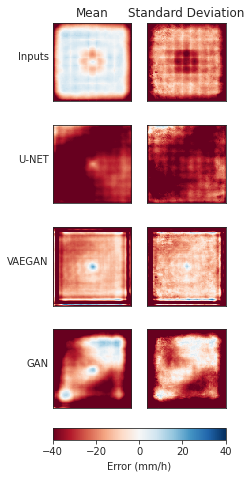

In [ ]:
plot='show'
n = 4
m = 2
if plot == 'save':
		fig, axes = plt.subplots(n, m, figsize=(5*m, 5*n), sharey=True)
else:
		print('show')
		fig, axes = plt.subplots(n, m, figsize=(2*m, 2*n), sharey=True)

axes[0,0].imshow(mean_anom_inputs, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[1,0].imshow(mean_anom_unet, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[2,0].imshow(mean_anom_vaegan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[3,0].imshow(mean_anom_dsrnngan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[0,1].imshow(std_anom_inputs, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[1,1].imshow(std_anom_unet, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[2,1].imshow(std_anom_vaegan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
m = axes[3,1].imshow(std_anom_dsrnngan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])


fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.3, 0.15, 0.6, 0.02])
cbar = fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbar.set_label('Error (mm/h)')

# set all titles and labels
fig.subplots_adjust(left=0.3)
axes[0,0].set_title('Mean')
axes[0,1].set_title('Standard Deviation')
axes[0,0].set_ylabel('Inputs',rotation=0,ha='right')
axes[1,0].set_ylabel('U-NET',rotation=0,ha='right')
axes[2,0].set_ylabel('VAEGAN',rotation=0,ha='right')
axes[3,0].set_ylabel('GAN',rotation=0,ha='right')
plt.show()

In [ ]:
# https://github.com/christianversloot/machine-learning-articles/blob/main/using-constant-padding-reflection-padding-and-replication-padding-with-keras.md